# Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Preprocess Output

In [2]:
def preprocess(file):
    df = pd.read_csv(file) #load file
    bins = [0,20, 30, 40, 50, 60, 70] #create bins for age brackets
    df['Age Bracket'] = pd.cut(df['age'], bins) #create age brackets
    df['isAutomatic'] = df['isAutomatic'].fillna(0) #fill na with 0
    df['time_sec'] = pd.to_datetime(df['taskDate'], unit='s', origin='unix') #format datetime
    #get the previous row value to identify number of rows per game and get seconds gap between each tap 8 to 10
    df['counter_previous'] = df['counter'].shift(1).fillna(0)
    df['user_previous'] = df['userID'].shift(1).fillna(0)
    df['auto_previous'] = df['isAutomatic'].shift(1).fillna(0)
    df['time_previous'] = df['time_sec'].shift(1).fillna(0)
    #get the delta value of previous tap and current tap 13 to 15
    df['counter_result'] = df['counter'] - df['counter_previous']
    df['user_result'] = df['userID'] - df['user_previous']
    df['auto_result'] = df['isAutomatic'] - df['auto_previous']
    df['time_previous'] = pd.to_datetime(df['time_previous'], errors='coerce') #format datetime field time_previos
    #if counter increment is 1 user and game type remain same then same game is going on give me time 
    #difference between 2 taps else new game has started give me 0 19 to 23
    df.loc[(df['counter_result'] == 1) & (df['user_result'] == 0) & (df['auto_result'] == 0), 'seconds'] =\
    ((pd.to_datetime(df['time_sec']) - 
                                pd.to_datetime(df['time_previous']))
                                    .dt.total_seconds())
    df.loc[(df['counter_result'] != 1) | (df['user_result'] != 0) | (df['auto_result'] != 0), 'seconds'] = 0
    #same logic and flagging if same game is being played from previous row to current row 25 & 26
    df.loc[(df['counter_result'] == 1) & (df['user_result'] == 0) & (df['auto_result'] == 0), 'reaction'] = 1
    df.loc[(df['counter_result'] != 1) | (df['user_result'] != 0) | (df['auto_result'] != 0), 'reaction'] = 0
    df['game_no']=df['reaction'].eq(0).cumsum() #tag game number and increment when flag 0 is found in reaction column
    #create a column to see if tap was error by checking tap done but was not a match 29 & 30
    df.loc[(df['isMatch'] == 0) & (df['entryType'] == 'SYMBOL') , 'Wrong Tap'] = 1 
    df['Wrong Tap'] = df['Wrong Tap'].fillna(0)
    #create a column if tap was missed 32 & 33
    df.loc[(df['entryType'] == 'MISS') , 'Miss'] = 1
    df['Miss'] = df['Miss'].fillna(0)
    #get the running sum per each game of match tap, error, miss and seconds per tab 35 to 38
    df['isMatchcum'] = df.groupby('game_no')['isMatch'].transform(pd.Series.cumsum)
    df['isErrorcum'] = df.groupby('game_no')['Wrong Tap'].transform(pd.Series.cumsum)
    df['isMisscum'] = df.groupby('game_no')['Miss'].transform(pd.Series.cumsum)
    df['timecum'] = df.groupby('game_no')['seconds'].transform(pd.Series.cumsum)
    time_bin = [0, 60, 120, 180, 240, 300] #create bin for running sum time bracket
    df['Time Interval'] = pd.cut(df['timecum'], time_bin) #create running sum time bracket                                                  
    df.loc[(df['isAutomatic'] == 0),'isAutomatic']='Non-Calibrated'
    df.loc[(df['isAutomatic'] == 1),'isAutomatic']='Calibrated' #name values
    df.rename(columns = {'isMatch':'Correct Tap', 'isAutomatic': 'GameType'}, inplace=True) #rename columns
    df = df.drop(['counter', 'sessionID', 'taskDate', 'entryType', 'entryID', 'figureID', 'tapTime', 'currentRules',\
             'fsmc_cog', 'fsmc_cog_class', 'cognitive_fatigued', 'edss_group', 'time_sec', 'counter_previous',\
             'user_previous', 'auto_previous', 'time_previous', 'counter_result', 'user_result','auto_result',\
             'reaction'], axis = 1) #drop unneccesassary column
    preprocess.newdf = df

# Function for Pivot

In [3]:
def pivot():
    #get the summary of each game by pivoting the data 42 to 44
    data = pd.pivot_table(preprocess.newdf, \
                          index = ['game_no', 'GameType', 'userID'],\
                          values = ['seconds', 'Correct Tap', 'Wrong Tap', 'Miss'], \
                          aggfunc ={'seconds': np.sum, 'Correct Tap':np.sum, 'Wrong Tap': np.sum, 'Miss': np.sum })
    pivot.summarize = pd.DataFrame(data.to_records()) #convert pivot to dataframe
    temp_file = preprocess.newdf[['userID', 'age', 'Age Bracket', 'Gender', 'EDSS']] #generate a temp file with column
    #of interest
    pivot.summarize = pd.merge(pivot.summarize, temp_file, how='left', on = 'userID') #get columns of interest
    pivot.summarize = pivot.summarize.drop_duplicates() #drop duplicate rows generating due to data merge
    pivot.summarize['No of Reacts'] = pivot.summarize['Correct Tap'] + pivot.summarize['Wrong Tap'] + \
    pivot.summarize['Miss'] #generate reaction time
    pivot.summarize['Average Reaction Time (ms)'] =  pivot.summarize['seconds'] / pivot.summarize['No of Reacts'] * 1000
    timeinterval = pd.pivot_table(preprocess.newdf,\
                          index = ['game_no','GameType','Time Interval'], \
                          values = ['Correct Tap', 'Wrong Tap', 'Miss','seconds'], \
                          aggfunc ={'Correct Tap':np.sum, 'Wrong Tap': np.sum, 'Miss': np.sum, \
                                    'seconds': np.sum }) #create a new pivot 
    #for time interval
    pivot.timeinterval = pd.DataFrame(timeinterval.to_records()) #convert pivot to dataframe
    pivot.timeinterval['No of Reacts'] = pivot.timeinterval['Correct Tap'] + pivot.timeinterval['Wrong Tap'] + \
    pivot.timeinterval['Miss'] #generate reaction time
    pivot.timeinterval['Average Reaction Time (ms)'] =  pivot.timeinterval['seconds'] / pivot.timeinterval['No of Reacts']\
    *1000
    pivot.calibrated = pivot.timeinterval[(pivot.timeinterval['GameType'] == 'Calibrated')]
    pivot.non_calibrated = pivot.timeinterval[(pivot.timeinterval['GameType'] == 'Non-Calibrated')]

# Massage summarize data

In [4]:
def massage():
    seconds_list = pivot.summarize['seconds'].tolist() #convert sum of seconds per game into list
    quart = [number / 4 for number in seconds_list] #divide the total seconds per game by 4 to get seconds in 1 quarter
    game_count = pivot.summarize['game_no'].tolist() #get the game number in list
    match_first_quart = [] #create an empty list 
    for (i, g) in zip (quart, game_count) : #get number of matches in 1st quarter in a list
        temp_df = preprocess.newdf[(preprocess.newdf['game_no'] == g)]
        x = temp_df.iloc[(np.searchsorted(temp_df['timecum'].values, i) - 1).clip(0)]
        result = x.get(key = 'isMatchcum')
        match_first_quart.append(result)
    pivot.summarize['CorrectTap1stQ'] = match_first_quart #append the 1st quart value in summarize df
    thrid_quart = [number * 3 for number in quart] #get total number of seconds in 3 seconds in a list
    match_last_quart = [] #create an empty list
    for (i, g) in zip (thrid_quart, game_count) : #get the total number of matches in 3 quarters in a list
        temp_df = preprocess.newdf[(preprocess.newdf['game_no'] == g)]
        x = temp_df.iloc[(np.searchsorted(temp_df['timecum'].values, i) - 1).clip(0)]
        result = x.get(key = 'isMatchcum')
        match_last_quart.append(result)
    pivot.summarize['ismatch3quart'] = match_last_quart #get total matches of 3 quarters
    pivot.summarize['CorrectTap4thQ'] = pivot.summarize['Correct Tap'] - pivot.summarize['ismatch3quart'] #subtract
    #total matches from 3 quarters from total matches to get total matches from 4th quarter
    # repeat 5 to 20 to get error counts
    preprocess.newdf['totalerror_cum'] = preprocess.newdf['isErrorcum'] + preprocess.newdf['isMisscum']
    pivot.summarize['Total Error'] = pivot.summarize['Wrong Tap'] + pivot.summarize['Miss']
    error_first_quart = [] #create an empty list 
    for (i, g) in zip (quart, game_count) : #get number of matches in 1st quarter in a list
        temp_df = preprocess.newdf[(preprocess.newdf['game_no'] == g)]
        x = temp_df.iloc[(np.searchsorted(temp_df['timecum'].values, i) - 1).clip(0)]
        result = x.get(key = 'totalerror_cum')
        error_first_quart.append(result)
    pivot.summarize['Error1stQ'] = error_first_quart #append the 1st quart value in summarize df
    error_last_quart = [] #create an empty list
    for (i, g) in zip (thrid_quart, game_count) : #get the total number of matches in 3 quarters in a list
        temp_df = preprocess.newdf[(preprocess.newdf['game_no'] == g)]
        x = temp_df.iloc[(np.searchsorted(temp_df['timecum'].values, i) - 1).clip(0)]
        result = x.get(key = 'totalerror_cum')
        error_last_quart.append(result)
    pivot.summarize['iserror3quart'] = error_last_quart #get total errors of 3 quarters
    pivot.summarize['Error4thQ'] = pivot.summarize['Total Error'] - pivot.summarize['iserror3quart'] #subtract
    #total matches from 3 quarters from total matches to get total matches from 4th quarter
    
    massage.summarize = pivot.summarize

# Call all the functions

In [5]:
preprocess('Final.csv')

In [6]:
pivot()

In [7]:
massage()

# Particpants Demography

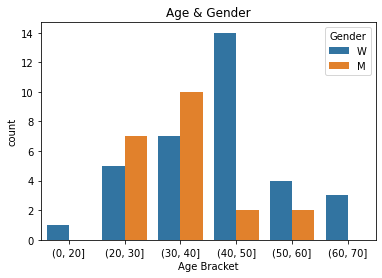

In [28]:
g = sns.countplot(x = 'Age Bracket', hue = 'Gender',\
            data = massage.summarize )
g.set_title('Age & Gender')
g.figure.savefig("Age & Gender.png")

In [9]:
stat = pd.DataFrame({'Measure': ['Min', 'Mean', 'Max']})
min_age = massage.summarize['age'].min()
mean_age = massage.summarize['age'].mean()
max_age = massage.summarize['age'].max()
age = [min_age, mean_age, max_age]
stat['Age'] = age

min_edss = massage.summarize['EDSS'].min()
mean_edss = massage.summarize['EDSS'].mean()
max_edss = massage.summarize['EDSS'].max()
edss = [min_edss, mean_edss, max_edss]
stat['EDSS'] = edss
stat.round(2)

,Measure,Age,EDSS
0,Min,19.00,0.00
1,Mean,39.47,2.17
2,Max,67.00,6.60


# Overall Comparison

In [10]:
column = ['Wrong Tap', 'Correct Tap', 'No of Reacts']

for c in column:
    res = massage.summarize.groupby('GameType').agg({c: ['std','min', 'mean', 'max']})
    res = res.round(2)
    display(res)

Wrong Tap                  
                     std  min   mean   max
GameType                                  
Calibrated          9.48  2.0  12.73  29.0
Non-Calibrated      1.90  0.0   2.18   8.0

Correct Tap                 
                       std min    mean  max
GameType                                   
Calibrated           29.33  16  100.00  127
Non-Calibrated       26.29  53  118.86  172

No of Reacts                     
                        std   min    mean    max
GameType                                        
Calibrated            41.14  26.0  129.27  186.0
Non-Calibrated        26.52  56.0  121.05  175.0

# Time Interval Analysis

Time Interval Analysis for Wrong Taps, Correct Taps and Total No of Reacts

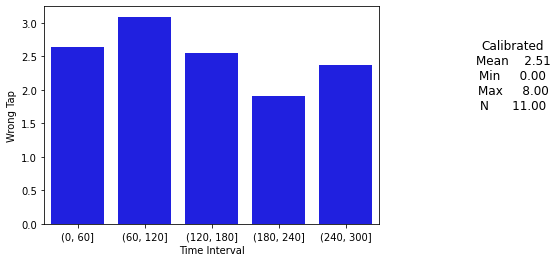

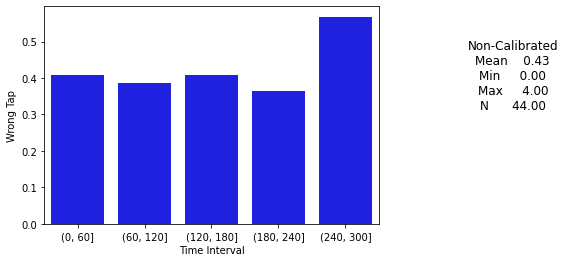

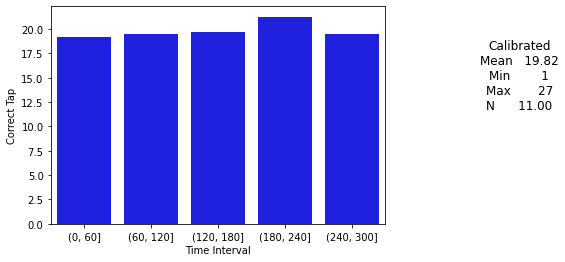

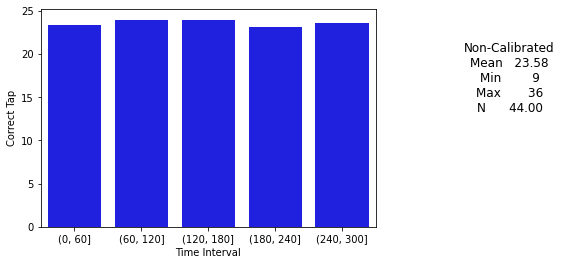

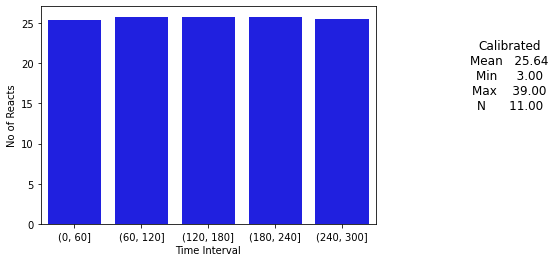

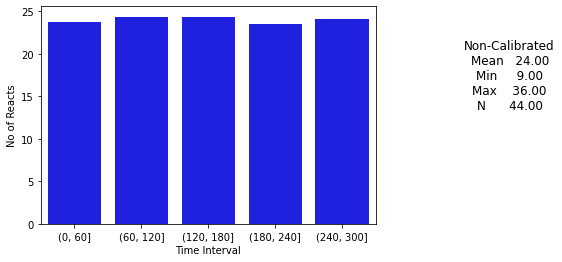

In [26]:
header = ['Calibrated', 'Non-Calibrated']
file = [pivot.calibrated, pivot.non_calibrated]
n = len(pd.unique(pivot.timeinterval['Time Interval']))
for c in column:
    for (h,f) in zip (header, file):
        plt.figure()
        stat = pivot.timeinterval.groupby(['GameType']).agg({c : ['mean', 'min', 'max', 'count']})
        stat.columns = ['Mean', 'Min' , 'Max', 'N']
        stat['N'] = stat['N'] / n
        stat = stat.reset_index()
        pd.options.display.float_format = '{:.2f}'.format
        stat = stat.T
        new_header = stat.iloc[0]
        stat = stat[1:]
        stat.columns = new_header
        stat = stat[h]
        title = stat.to_string()
        
        g = sns.barplot(x = 'Time Interval', y = c, estimator = np.mean, data = f, \
                   ci=None, color = 'blue' )
        g.set_title(h + "\n" + title, x = 1.4, y =0.5)
        
        g.figure.savefig(h + " - " + c + ".png")
        

Time Interval for Missed Tap for Calibrated Game

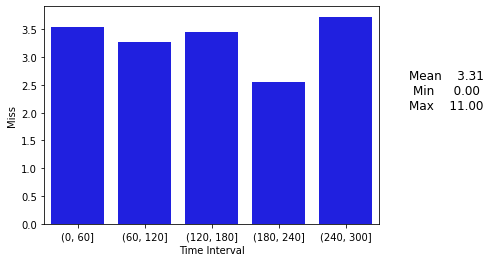

In [29]:
stat = pivot.timeinterval.groupby(['GameType']).agg({'Miss' : ['mean', 'min', 'max']})
stat.columns = ['Mean', 'Min' , 'Max']
stat = stat.reset_index()
pd.options.display.float_format = '{:.2f}'.format
stat = stat.T
new_header = stat.iloc[0]
stat = stat[1:]
stat.columns = new_header
stat = stat['Calibrated']

title = stat.to_string()

g = sns.barplot(x = 'Time Interval', y = 'Miss', estimator = np.mean, data = pivot.calibrated, \
           ci=None, color = 'blue' )
g.set_title(title, x = 1.2, y =0.5)
g.figure.savefig('Miss Taps.png')

Time Interval for Average Reaction Time per second

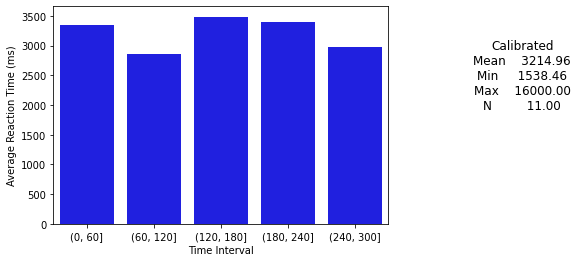

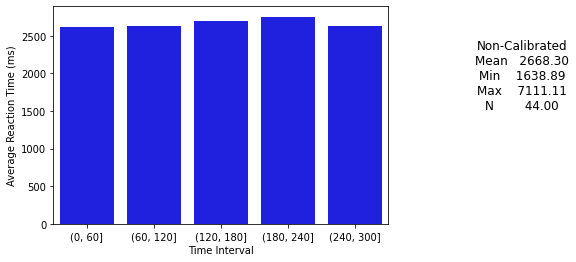

In [30]:
for (h,f) in zip (header, file):
    plt.figure()
    stat = pivot.timeinterval.groupby(['GameType']).agg({'Average Reaction Time (ms)' : ['mean', 'min', 'max', 'count']})
    stat.columns = ['Mean', 'Min' , 'Max', 'N']
    stat['N'] = stat['N'] / n
    stat = stat.reset_index()
    pd.options.display.float_format = '{:.2f}'.format
    stat = stat.T
    new_header = stat.iloc[0]
    stat = stat[1:]
    stat.columns = new_header
    stat = stat[h]
    title = stat.to_string()

    g = sns.barplot(x = 'Time Interval', y = 'Average Reaction Time (ms)', estimator = np.mean, data = f, \
               ci=None, color = 'blue' )
    g.set_title(h + "\n" + title, x = 1.4, y =0.5)
    g.figure.savefig(h + " - Average Reaction Time (ms).png")   

Time Interval Comparison in Tabular View


In [14]:
for c in column:
    res = pd.pivot_table(pivot.timeinterval, values =c, index ='GameType', columns = 'Time Interval',
                    aggfunc={c: np.mean})
    res = res.round(2)
    print(c)
    print("Mean")
    display(res)

Wrong Tap
Mean


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,2.64,3.09,2.55,1.91,2.36
Non-Calibrated,0.41,0.39,0.41,0.36,0.57


Correct Tap
Mean


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,19.18,19.45,19.73,21.27,19.45
Non-Calibrated,23.32,23.98,23.91,23.11,23.57


No of Reacts
Mean


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,25.36,25.82,25.73,25.73,25.55
Non-Calibrated,23.73,24.36,24.32,23.48,24.14


In [15]:
for c in column:
    res = pd.pivot_table(pivot.timeinterval, values =c, index ='GameType', columns = 'Time Interval',
                    aggfunc={c: np.std})
    res = res.round(2)
    print(c)
    print ("Standard Deviation")
    display(res)

Wrong Tap
Standard Deviation


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,2.38,2.77,2.25,1.92,2.11
Non-Calibrated,0.66,0.62,0.92,0.57,0.82


Correct Tap
Standard Deviation


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,6.32,5.61,6.28,7.14,5.45
Non-Calibrated,5.19,5.40,5.43,5.74,5.39


No of Reacts
Standard Deviation


Time Interval,"(0, 60]","(60, 120]","(120, 180]","(180, 240]","(240, 300]"
GameType,,,,,
Calibrated,9.01,8.15,8.99,8.20,7.42
Non-Calibrated,5.22,5.40,5.61,5.71,5.39


# Compare Games in 1st Quarter and 4th Quarter

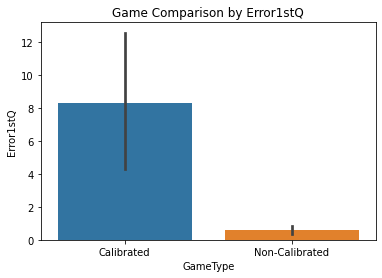

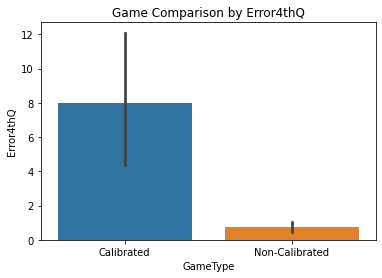

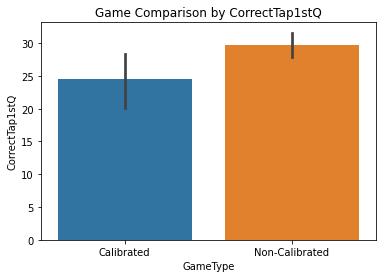

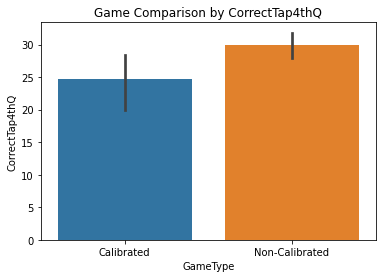

In [32]:
quart_list = ['Error1stQ', 'Error4thQ', 'CorrectTap1stQ', 'CorrectTap4thQ']

for q in quart_list:
    plt.figure()
    res = sns.barplot(x='GameType', y=q, estimator = np.mean, data = massage.summarize)
    res.set_title('Game Comparison by '+q)
    res.figure.savefig('Game Comparison by '+q+'.png')
    

# Compare 1st and 4th quarter of Calibrated and Non-Calibrated

In [17]:
row_count = len(massage.summarize.index)
error1stquart = []
error4thquart = []
correct1stquart = []
correct4thquart = []
for i in range(0,row_count):
    error1stquart.append("Error1stQ")
    error4thquart.append('Error4thQ')
    correct1stquart.append('CorrectTap1stQ')
    correct4thquart.append('CorrectTap4thQ')
error1stvalue = massage.summarize['Error1stQ'].tolist()
error4thvalue = massage.summarize['Error4thQ'].tolist()
correct1stvalue = massage.summarize['CorrectTap1stQ'].tolist()
correct4thvalue = massage.summarize['CorrectTap4thQ'].tolist()
error1stquart.extend(error4thquart)
correct1stquart.extend(correct4thquart)
error1stvalue.extend(error4thvalue)
correct1stvalue.extend(correct4thvalue)
game = massage.summarize['GameType'].tolist()
game1 = game
game.extend(game1)
chart = pd.DataFrame()
chart['GameType'] = game
chart['ErrorQuart'] = error1stquart
chart['Error'] = error1stvalue
chart['CorrectQuart'] = correct1stquart
chart['CorrectTap'] = correct1stvalue
chart.to_csv('chart.csv')
dimension = ['ErrorQuart', 'CorrectQuart']
measure = ['Error', 'CorrectTap']

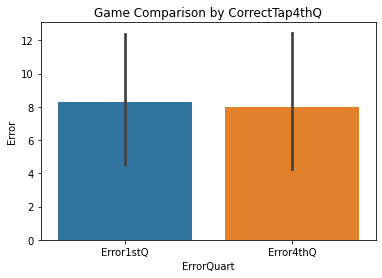

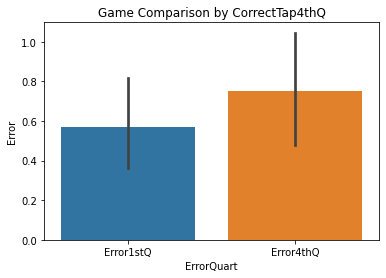

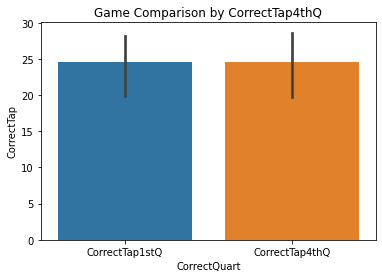

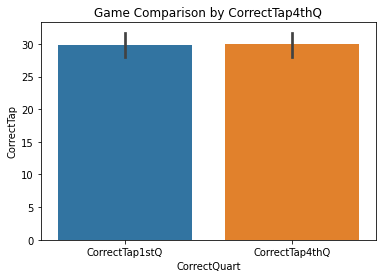

In [40]:
for (x, y) in zip(dimension, measure):
    for h in header:
        data = chart.loc[chart['GameType'] == h]
        plt.figure()
        res = sns.barplot(x=x, y=y, estimator = np.mean, data = data)
        res.set_title('Game Comparison by '+q)
        res.figure.savefig("Compare 1st & 4th quarter - " + y + " - " + h+".png")

# OTHERS

# Average Reaction Time

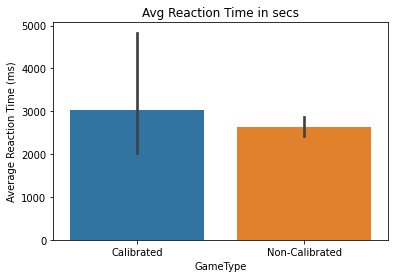

In [35]:
res = sns.barplot(x='GameType', y= pivot.summarize['Average Reaction Time (ms)'] , estimator = np.mean, \
                  data = massage.summarize)
res.set_title('Avg Reaction Time in secs')
res.figure.savefig("Avg Reaction Time in secs")

# Compare Distribution of Taps Across Both the Games

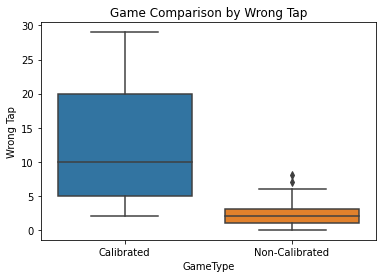

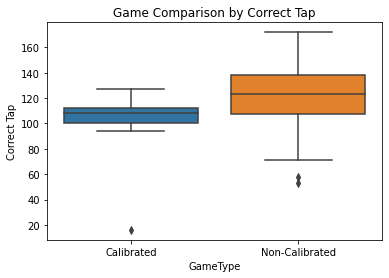

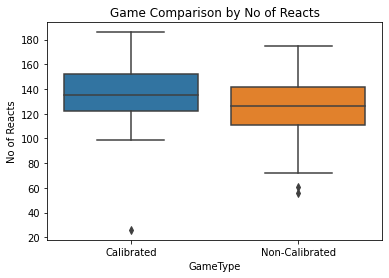

In [37]:
for c in column:
    plt.figure()
    g = sns.boxplot(x = 'GameType', y = c, data = massage.summarize)
    g.set_title('Game Comparison by ' + c)
    g.figure.savefig('Compare Distribution of ' + c +'.png')

# Age & Performance Relationship

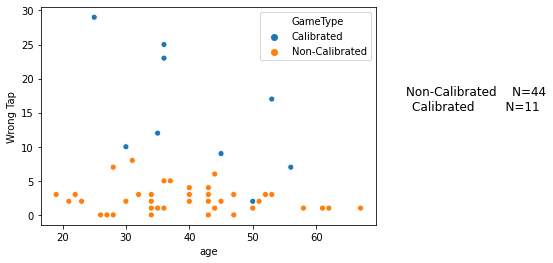

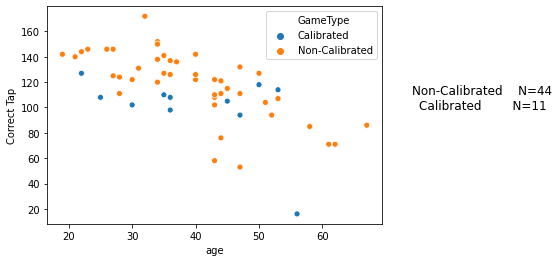

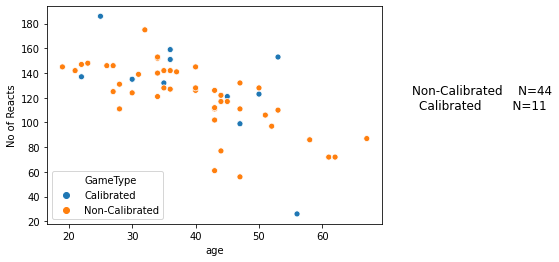

In [38]:
stat = massage.summarize['GameType'].value_counts()
stat = stat.to_frame()
stat['GameType'] = stat['GameType'].astype(str)
stat = 'N='+ stat['GameType']
title = stat.to_string()
for c in column:
    plt.figure()
    g = sns.scatterplot(x = 'age', y = c, data = massage.summarize, hue = 'GameType' )
    g.set_title(title, x = 1.3, y =0.5)
    g.figure.savefig('Relationship between age & '+c +'.png')